**Akash Sharma (EE21S056)**

*EE5179: Deep Learning for Imaging*

# Comparing PCA and Autoencoders

## Importing packages

In [1]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
from torch import nn
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

## Loading MNIST dataset

In [2]:
training_data = datasets.MNIST(root="data", train=True, download = True,transform = ToTensor())
test_data = datasets.MNIST(root="data", train = False, download = True,transform = ToTensor())

batch_size = 64

train_loader = DataLoader(dataset=training_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

## MNIST Image Reconstruction using PCA

Reference used: https://analyticsindiamag.com/guide-to-image-reconstruction-using-principal-component-analysis/

In [3]:
# Extracting just images from the dataset for PCA

images = training_data.data 
print(images.shape)

torch.Size([60000, 28, 28])


### Finding indices representing each class

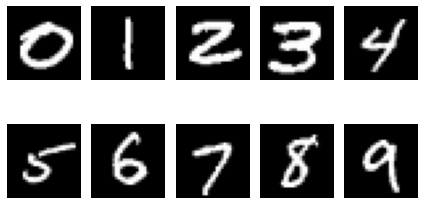

In [4]:
# 114-0, 102-1, 117-2, 111-3, 115-4, 145-5, 106-6, 103-7, 125-8, 110-9 

idx_PCA = [114, 102, 117, 111, 115, 145, 106, 103, 125, 110]

i=1 #just an iterator variable

for idx in idx_PCA:
  plt.subplot(2,5,i)
  plt.imshow(images[idx].reshape(28,28), cmap='gray')
  plt.axis('off')
  i+=1
plt.tight_layout()
plt.show()

### Flattening PCA input images

In [5]:
data = np.zeros((60000, 784))
k=0
for img in images:
  data[k] = img.squeeze().flatten()
  data[k] = data[k]/255
  k+=1
print(data.shape)

(60000, 784)


### Performing PCA and checking reconstruction error

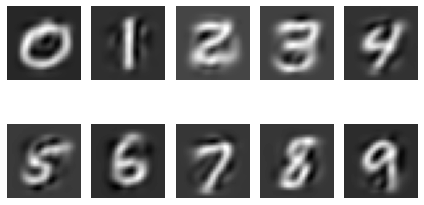

Reconstruction error for PCA is  0.018121850503857066


In [6]:
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
pca = PCA(n_components=30)
reconst_data = pca.inverse_transform(pca.fit_transform(data))

i = 1

for idx in idx_PCA:
  plt.subplot(2,5,i)
  plt.imshow(reconst_data[idx].reshape(28,28), cmap='gray')
  plt.axis('off')
  i+=1

plt.tight_layout()
plt.show()

print('Reconstruction error for PCA is ', mean_squared_error(data, reconst_data))

## Using an Autoencoder on MNIST dataset

### Defining stacked autoencoder class

In [7]:
class stack_AE(nn.Module):
  def __init__(self):
    super(stack_AE, self).__init__()
    self.flatten = nn.Flatten()
    self.encoder = nn.Sequential(
        nn.Linear(784,512),
        nn.ReLU(),
        nn.Linear(512,256),
        nn.ReLU(),
        nn.Linear(256,128),
        nn.ReLU(),
        nn.Linear(128,30),
        nn.ReLU())
    self.decoder =nn.Sequential(
        nn.Linear(30,128),
        nn.ReLU(),
        nn.Linear(128,256),
        nn.ReLU(),
        nn.Linear(256,784),
        nn.ReLU())
    
  def forward(self, x):
    x = self.flatten(x)
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded, encoded

### Autoencoder Training

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

learning_rate = 0.001
epochs = 10
 
criterion = nn.MSELoss() # Reconstruction error is defined as the MSE Loss

model_stackAE = stack_AE().to(device)
optimizer = torch.optim.Adam(model_stackAE.parameters(), learning_rate)

train_batch_loss = []
train_epoch_loss = []
val_loss = []

In [9]:
for epoch in range(epochs):
  for batch_idx, (data, target) in enumerate(train_loader):
    data = data.to(device)
    target = target.to(device)

    model_stackAE.train()
    decoded, encoded = model_stackAE(data)
    loss = criterion(decoded, torch.flatten(data,1))
    train_batch_loss.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_epoch_loss.append(train_batch_loss[-1])
  
  model_stackAE.eval()
  with torch.no_grad():
    for (data, target) in test_loader:
      data = data.to(device)
      target = target.to(device)
      decoded, encoded = model_stackAE(data)
      val_iter_loss = criterion(decoded, torch.flatten(data,1))

  val_loss.append(val_iter_loss.item())
  print('Epoch Number: ',epoch+1)
  print('Training loss: ', train_epoch_loss[-1])
  print('Validation loss: ', val_loss[-1])
  print('-----------------------------------------')

print('Training done!')

Epoch Number:  1
Training loss:  0.02948594279587269
Validation loss:  0.025837989524006844
-----------------------------------------
Epoch Number:  2
Training loss:  0.02277982421219349
Validation loss:  0.020370956510305405
-----------------------------------------
Epoch Number:  3
Training loss:  0.01931915245950222
Validation loss:  0.018611568957567215
-----------------------------------------
Epoch Number:  4
Training loss:  0.02137576974928379
Validation loss:  0.017161209136247635
-----------------------------------------
Epoch Number:  5
Training loss:  0.018504636362195015
Validation loss:  0.01636418327689171
-----------------------------------------
Epoch Number:  6
Training loss:  0.020677324384450912
Validation loss:  0.01690388098359108
-----------------------------------------
Epoch Number:  7
Training loss:  0.016058238223195076
Validation loss:  0.016165537759661674
-----------------------------------------
Epoch Number:  8
Training loss:  0.015046187676489353
Validat

### Visualizing training and validation loss for autoencoder

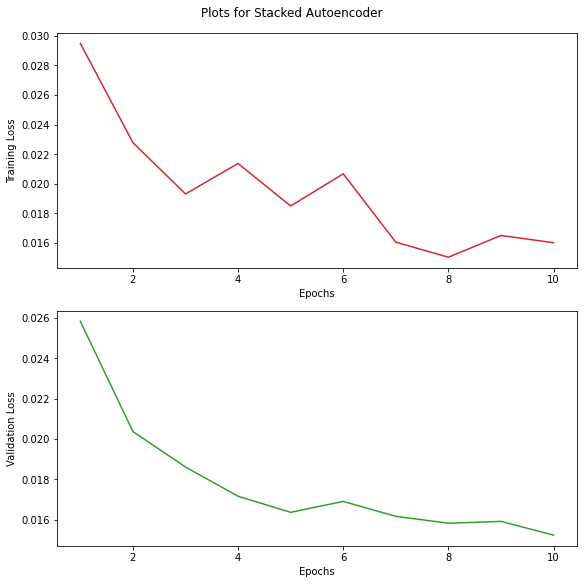

In [10]:
fig, axs = plt.subplots(2, constrained_layout= True, figsize=(8,8))
fig.suptitle('Plots for Stacked Autoencoder')
axs[0].set(ylabel='Training Loss', xlabel='Epochs')
axs[0].plot(range(1,epochs+1),train_epoch_loss, 'tab:red')
axs[1].set(ylabel='Validation Loss', xlabel='Epochs')
axs[1].plot(range(1,epochs+1),val_loss, 'tab:green')

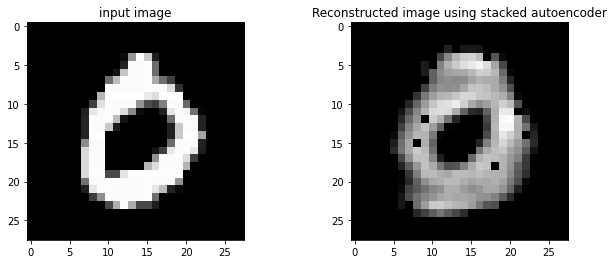

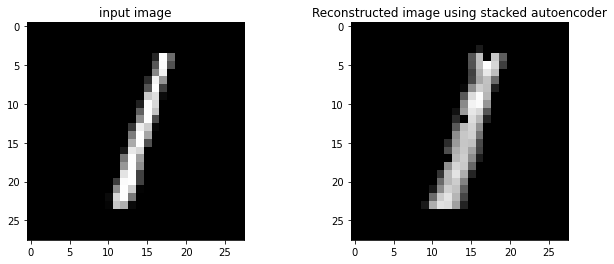

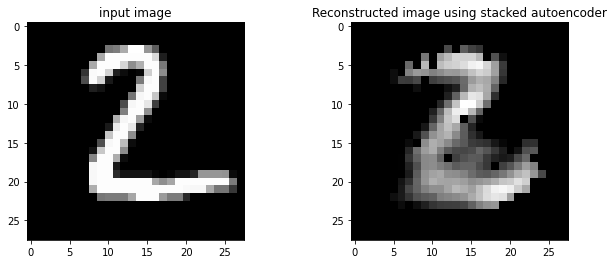

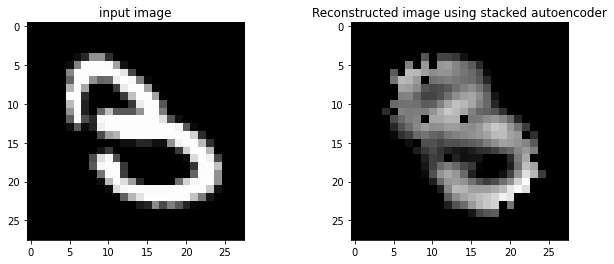

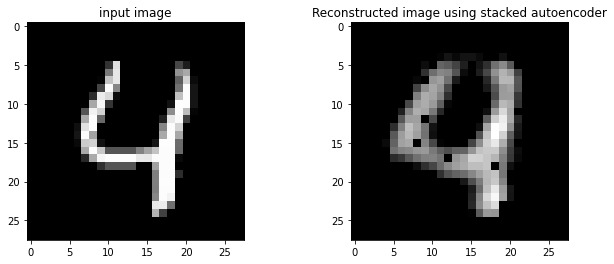

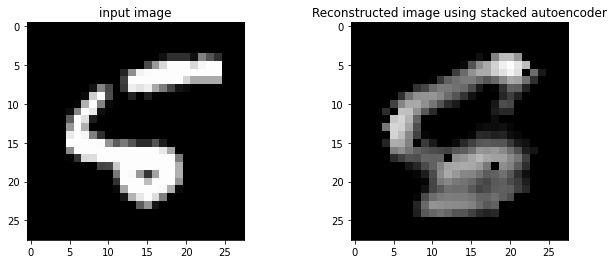

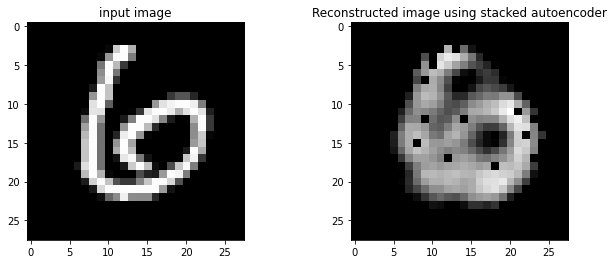

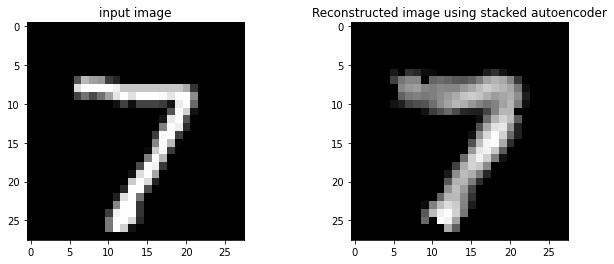

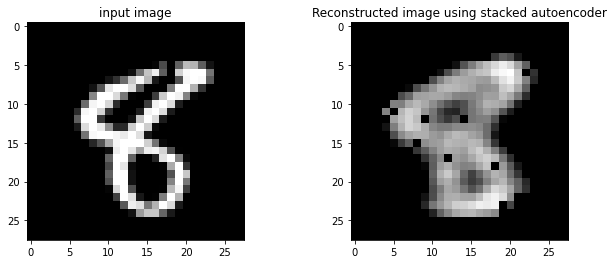

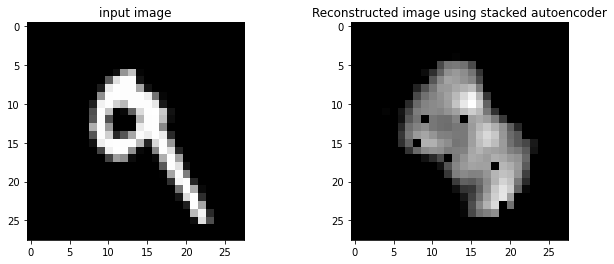

In [11]:
idx_test=[3,2,1,18,4,8,11,0,84,7]

for idx in idx_test:
  image = test_loader.dataset.data[idx, :, :].clone()
  with torch.no_grad():
    image = image.view(-1,28,28).to(device=device).float()
    decoded, encoded = model_stackAE.forward(image)
    decoded = decoded.detach().cpu().numpy()
    image = image.reshape(28,28).detach().cpu().numpy()
    plt.subplot(1,2,1)
    plt.imshow(image , cmap='gray')
    plt.title('input image')
    plt.subplots_adjust(right=1.5)
    plt.subplot(1,2,2)
    plt.imshow(decoded.reshape(28,28),cmap ='gray')
    plt.title("Reconstructed image using stacked autoencoder")
    plt.show()

In [12]:
model_stackAE.eval()
test_loss = 0
with torch.no_grad():
  for (data, target) in test_loader:
    data = data.to(device)
    target = target.to(device)
    decoded, encoded = model_stackAE(data)
    val_iter_loss = criterion(decoded, torch.flatten(data,1))
    test_loss += val_iter_loss/len(test_loader)
  
print('Reconstruction accuracy with the given autoencoder configuration is ', test_loss.item())

Reconstruction accuracy with the given autoencoder configuration is  0.01669379137456417


# Experimenting with hidden units of varying sizes

## Defining standard autoencoder class

The following model takes the size of hidden layer as input as required by the experiment.

In [13]:
class standard_AE(nn.Module):
  def __init__(self,hidden_layer):
    super(standard_AE, self).__init__()
    self.flatten = nn.Flatten()
    self.encoder = nn.Sequential(
        nn.Linear(784,hidden_layer),
        nn.ReLU())
    self.decoder =nn.Sequential(
        nn.Linear(hidden_layer,784),
        nn.ReLU())


  def forward(self,x):
    x = self.flatten(x)
    encoded=self.encoder(x)
    decoded =self.decoder(encoded)
    return decoded, encoded 

## Loading Fashion MNIST for experiment

In [14]:
fash_test_data = datasets.FashionMNIST(root="data", train = False, download = True,transform = ToTensor())
fash_test_loader = DataLoader(dataset=fash_test_data, batch_size=batch_size, shuffle=False)

## Training and experiment results

In [ ]:
hid_size = [64, 128, 256]

for size in hid_size:
  model_standardAE = standard_AE(size).to(device)
  optimizer = torch.optim.Adam(model_standardAE.parameters(), learning_rate)

  train_batch_loss = []
  train_epoch_loss = []
  val_loss = [] 
  print('Training begins for hidden unit size ', size, '!')
  print('-----------------------------------------------------------')
  for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
      data = data.to(device=device)
      target = target.to(device=device)

      model_standardAE.train()
      decoded, encoded = model_standardAE(data)
      loss = criterion(decoded, torch.flatten(data,1))
      train_batch_loss.append(loss.item())

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    train_epoch_loss.append(train_batch_loss[-1])
  
    model_standardAE.eval()
    with torch.no_grad():
      for (data, target) in test_loader:
        data = data.to(device)
        target = target.to(device)
        decoded, encoded = model_standardAE(data)
        val_iter_loss = criterion(decoded, torch.flatten(data,1))

    val_loss.append(val_iter_loss.item())
    print('Epoch Number: ',epoch+1)
    print('Training loss: ', train_epoch_loss[-1])
    print('Validation loss: ', val_loss[-1])
    print('-----------------------------------------')


  fig, axs = plt.subplots(2, constrained_layout= True, figsize=(8,8))
  fig.suptitle('Plots for Standard Autoencoder')
  axs[0].set(ylabel='Training Loss', xlabel='Epochs')
  axs[0].plot(range(1,epochs+1),train_epoch_loss, 'tab:red')
  axs[1].set(ylabel='Validation Loss', xlabel='Epochs')
  axs[1].plot(range(1,epochs+1),val_loss, 'tab:green')
  plt.show()
  print('Training done for hidden unit size ', size, '!')
  print('-----------------------------------------------------------')
  image = test_loader.dataset.data[1, :, :].clone() #take one image from test set
  with torch.no_grad():
    image = image.view(-1,28,28).to(device=device).float()
    decoded, encoded = model_standardAE.forward(image)
    decoded = decoded.detach().cpu().numpy()
    image = image.reshape(28,28).detach().cpu().numpy()
    plt.subplot(1,2,1)
    plt.imshow(image , cmap='gray')
    plt.title('input image')
    plt.subplots_adjust(right=1.5)
    plt.subplot(1,2,2)
    plt.imshow(decoded.reshape(28,28),cmap ='gray')
    plt.title("Reconstructed image using standard AE hidden unit size "+str(size))
    plt.show()
    
    fash_image = fash_test_loader.dataset.data[12, :, :].clone()
    fash_image = fash_image.view(-1,28,28).to(device=device).float()
    decoded, encoded = model_standardAE.forward(fash_image)
    decoded = decoded.detach().cpu().numpy()
    fash_image = fash_image.reshape(28,28).detach().cpu().numpy()
    plt.subplot(1,2,1)
    plt.imshow(fash_image , cmap='gray')
    plt.title('input image')
    plt.subplots_adjust(right=1.5)
    plt.subplot(1,2,2)
    plt.imshow(decoded.reshape(28,28),cmap ='gray')
    plt.title("Reconstructed image using standard AE hidden unit size "+str(size))
    plt.show()


    noisy_img = np.random.normal(loc=128,scale=10,size=(28,28))
    noisy_img = torch.from_numpy(noisy_img).reshape(1,1,28,28).to(device=device).float()
    decoded, encoded = model_standardAE.forward(noisy_img)
    decoded = decoded.detach().cpu().numpy()
    noisy_img = noisy_img.reshape(28,28).detach().cpu().numpy()
    plt.subplot(1,2,1)
    plt.imshow(noisy_img , cmap='gray')
    plt.title('input image')
    plt.subplots_adjust(right=1.5)
    plt.subplot(1,2,2)
    plt.imshow(decoded.reshape(28,28),cmap ='gray')
    plt.title("Reconstructed image using standard AE hidden unit size "+str(size))
    plt.show()
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')

Training begins for hidden unit size  64 !
-----------------------------------------------------------
Epoch Number:  1
Training loss:  0.013325842097401619
Validation loss:  0.013729165308177471
-----------------------------------------
Epoch Number:  2
Training loss:  0.010477734729647636
Validation loss:  0.012638967484235764
-----------------------------------------
Epoch Number:  3
Training loss:  0.011704877950251102
Validation loss:  0.01246145274490118
-----------------------------------------
Epoch Number:  4
Training loss:  0.012843029573559761
Validation loss:  0.012602227739989758
-----------------------------------------
Epoch Number:  5
Training loss:  0.011977956630289555
Validation loss:  0.012281843461096287
-----------------------------------------
Epoch Number:  6
Training loss:  0.0108944708481431
Validation loss:  0.011952475644648075
-----------------------------------------
Epoch Number:  7
Training loss:  0.009793129749596119
Validation loss:  0.0123247150331735

# Sparse Autoencoders

## Defining sparse autoencoder class

In [ ]:
class overcomp_sparse_AE(nn.Module):
  def __init__(self):
    super(overcomp_sparse_AE, self).__init__()
    self.flatten = nn.Flatten()
    self.encoder = nn.Sequential(
        nn.Linear(784,1521),
        nn.ReLU())
    self.decoder =nn.Sequential(
        nn.Linear(1521,784),
        nn.ReLU())


  def forward(self,x):
    x = self.flatten(x)
    encoded=self.encoder(x)
    decoded =self.decoder(encoded)
    return decoded, encoded

## Defining experimentation functions

- Average hidden layer activation `avg_hl_activations`
- Visualize activations `visualize_activations`
- Visualize learned filters `encoder_decoder_filters_plots`

In [ ]:
def avg_hl_activations(model,test_dataloader,model_name):
    model.eval() 
    avg_act_val = 0
    with torch.no_grad():
        for (data,label) in test_dataloader: 
            (data,label) = (data.to(device),label.to(device))  
            decoded,encoded = model(data) #our prediction 
            avg_act_val += float(torch.mean(encoded))        
    avg_act_val /= len(test_dataloader)
    print("The average activation of "+ str(model_name)+" is",avg_act_val)

def encoder_decoder_filters_plots(model,model_name,device): 
    with torch.no_grad():
        encoder_filters = model.encoder[0].weight.detach().cpu().numpy()
        decoder_filters = model.decoder[0].weight.detach().cpu().numpy()
        #plot the encoder and decoder weights as an image for 0th neuron
        plt.imshow(encoder_filters[0].reshape(28,28), cmap='gray')
        plt.colorbar()
        plt.title('Encoder Filters for '+str(0)+'th neuron of '+ str(model_name))
        plt.show()

        plt.imshow(decoder_filters[:,0].reshape(28,28), cmap='gray')
        plt.colorbar()
        plt.title('Decoder Filters for '+str(0)+'th neuron of '+ str(model_name))
        plt.show()

def visualize_activations(model,test_dataloader,model_name,device,hidden_layer): #visualize the activations
    for i,ind in enumerate(idx_test):
        test_image = test_dataloader.dataset.data[ind].clone()  
        test_label = test_dataloader.dataset.targets[ind].clone()
        with torch.no_grad(): 
            test_image = test_image.reshape(1,1,28,28).to(device=device).float() 
            decoded,encoded = model.forward(test_image) 
            encoded = encoded.detach().cpu().numpy()
            plt.imshow(encoded.reshape(int(np.sqrt(hidden_layer)),int(np.sqrt(hidden_layer))), cmap='gray') 
            str_title = "Activation for digit "+str(test_label.item())
            plt.title(str_title)
            plt.show()

In [ ]:
sparsity_values = [0.0001, 0.001, 0.005, 0.1]

for lam in sparsity_values:
  model_over_sparseAE = overcomp_sparse_AE().to(device)
  optimizer = torch.optim.Adam(model_over_sparseAE.parameters(), learning_rate)

  train_batch_loss = []
  train_epoch_loss = []
  val_loss = []
  print('Training begins for regularization lambda value ', lam, '!')
  print('-----------------------------------------------------------')
  for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
      data = data.to(device=device)
      target = target.to(device=device)

      model_over_sparseAE.train()
      decoded, encoded = model_over_sparseAE(data)
      loss = criterion(decoded, torch.flatten(data,1))
      loss+= lam*torch.linalg.norm(encoded, 1)
      train_batch_loss.append(loss.item())

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    train_epoch_loss.append(train_batch_loss[-1])
  
    model_over_sparseAE.eval()
    with torch.no_grad():
      for (data, target) in test_loader:
        data = data.to(device)
        target = target.to(device)

        decoded, encoded = model_over_sparseAE(data)
        val_iter_loss = criterion(decoded, torch.flatten(data,1))
        val_iter_loss += lam*torch.linalg.norm(encoded, 1)

    val_loss.append(val_iter_loss.item())
    print('Epoch Number: ',epoch+1)
    print('Training loss: ', train_epoch_loss[-1])
    print('Validation loss: ', val_loss[-1])
    print('-----------------------------------------')

  fig, axs = plt.subplots(2, constrained_layout= True, figsize=(8,8))
  fig.suptitle('Plots for Standard Autoencoder')
  axs[0].set(ylabel='Training Loss', xlabel='Epochs')
  axs[0].plot(range(1,epochs+1),train_epoch_loss, 'tab:red')
  axs[1].set(ylabel='Validation Loss', xlabel='Epochs')
  axs[1].plot(range(1,epochs+1),val_loss, 'tab:green')
  plt.show()
  print('Training done for regularization lambda value ', lam, '!')
  print('-----------------------------------------------------------')
  image = test_loader.dataset.data[1, :, :].clone() #take one image from test set
  with torch.no_grad():
    image = image.view(-1,28,28).to(device=device).float()
    decoded, encoded = model_over_sparseAE.forward(image)
    decoded = decoded.detach().cpu().numpy()
    image = image.reshape(28,28).detach().cpu().numpy()
    plt.subplot(1,2,1)
    plt.imshow(image , cmap='gray')
    plt.title('input image')
    plt.subplots_adjust(right=1.5)
    plt.subplot(1,2,2)
    plt.imshow(decoded.reshape(28,28),cmap ='gray')
    plt.title("Reconstructed image using Sparse AE with lambda value "+str(lam))
    plt.show()
    avg_hl_activations(model_over_sparseAE,test_loader,"Sparse AE with lambda value "+str(lam))
    encoder_decoder_filters_plots(model_over_sparseAE,"Sparse AE with lambda value"+str(lam),device)
    visualize_activations(model_over_sparseAE,test_loader,"Sparse AE with lambda value"+str(lam),device,1521)
  print('-----------------------------------------------------------')
  print('-----------------------------------------------------------')

# Denoising Autoencoders

## Experimentation with different noise values

In [ ]:
noise_values = [0.3, 0.5, 0.8, 0.9]

for noise_val in noise_values:
  model_denoiseAE = standard_AE(256).to(device)
  optimizer = torch.optim.Adam(model_denoiseAE.parameters(), learning_rate)

  train_batch_loss = []
  train_epoch_loss = []
  val_loss = []
  print('Training begins for noise value ', noise_val, '!')
  print('-----------------------------------------------------------') 
  for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(train_loader):

      noise = torch.randn(data.size())*noise_val
      data = data + noise
      data = data.to(device=device)
      target = target.to(device=device)

      model_denoiseAE.train()
      decoded, encoded = model_denoiseAE(data)
      loss = criterion(decoded, torch.flatten(data,1))
      train_batch_loss.append(loss.item())

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    train_epoch_loss.append(train_batch_loss[-1])
  
    model_denoiseAE.eval()
    with torch.no_grad():
      for (data, target) in test_loader:
        noise = torch.randn(data.size())*noise_val
        data = data + noise
        data = data.to(device=device)
        target = target.to(device)
        decoded, encoded = model_denoiseAE(data)
        val_iter_loss = criterion(decoded, torch.flatten(data,1))

    val_loss.append(val_iter_loss.item())
    print('Epoch Number: ',epoch+1)
    print('Training loss: ', train_epoch_loss[-1])
    print('Validation loss: ', val_loss[-1])
    print('-----------------------------------------')

  
  fig, axs = plt.subplots(2, constrained_layout= True, figsize=(8,8))
  fig.suptitle('Plots for Standard Autoencoder')
  axs[0].set(ylabel='Training Loss', xlabel='Epochs')
  axs[0].plot(range(1,epochs+1),train_epoch_loss, 'tab:red')
  axs[1].set(ylabel='Validation Loss', xlabel='Epochs')
  axs[1].plot(range(1,epochs+1),val_loss, 'tab:green')
  plt.show()
  print('Training done for denoising AE with noise value',noise_val,'!')
  print('-----------------------------------------------------------')
  test_image = test_loader.dataset.data[3, :, :].clone() #RANDOM TEST IMAGE
  noise = torch.randn(test_image.size())*noise_val
  image = test_image + noise
  with torch.no_grad():
    image = image.view(-1,28,28).to(device=device).float()
    decoded, encoded = model_over_sparseAE.forward(image)
    decoded = decoded.detach().cpu().numpy()
    image = image.reshape(28,28).detach().cpu().numpy()
    plt.subplot(1,2,1)
    plt.imshow(image , cmap='gray')
    plt.title('input image')
    plt.subplots_adjust(right=1.5)
    plt.subplot(1,2,2)
    plt.imshow(decoded.reshape(28,28),cmap ='gray')
    plt.title("Reconstructed image using Denoising AE with noise value "+str(noise_val))
    plt.show()
  encoder_decoder_filters_plots( model_denoiseAE,"Denoising AE with noise value"+str(noise_val),device)
  print('-----------------------------------------------------------')
  print('-----------------------------------------------------------')
